
# Drug Review Rating Prediction — **TF‑IDF vs. Transformer Embeddings** + Logistic Regression
## From 3‑Class Sentiment to 10‑Class Rating (Side‑by‑Side)



This notebook compares two approaches on the **Drugs.com reviews** dataset:

- **TF‑IDF + Logistic Regression** (classic linear text model)

- **SentenceTransformer Embeddings (`all-MiniLM-L6-v2`) + Logistic Regression** (modern semantic vectors)



We evaluate both on **two tasks**:

1) **3‑Class**: Negative (≤4), Neutral (5–6), Positive (≥7)

2) **10‑Class**: Exact rating 1–10



We report **Accuracy**, **Macro‑F1**, **Weighted‑F1**, and plot **Confusion Matrices**.



## 0) Setup (Colab)

In [ ]:

# If running on Google Colab, uncomment the following to install dependencies:
# !pip -q install scikit-learn==1.5.1 pandas==2.2.2 numpy==1.26.4 matplotlib==3.8.4
# !pip -q install nltk==3.9.1 sentence-transformers==3.2.1
# import nltk; nltk.download('wordnet'); nltk.download('omw-1.4'); nltk.download('stopwords')


## 1) Imports

In [ ]:

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

try:
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords
    lemm = WordNetLemmatizer()
    stop_en = set(stopwords.words('english'))
except Exception:
    lemm = None
    stop_en = set()


## 2) Load Data

In [ ]:

DATA_PATH = "drugsComTrain_raw.csv"
df = pd.read_csv(DATA_PATH, engine="python")
df.head()


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


## 3) EDA

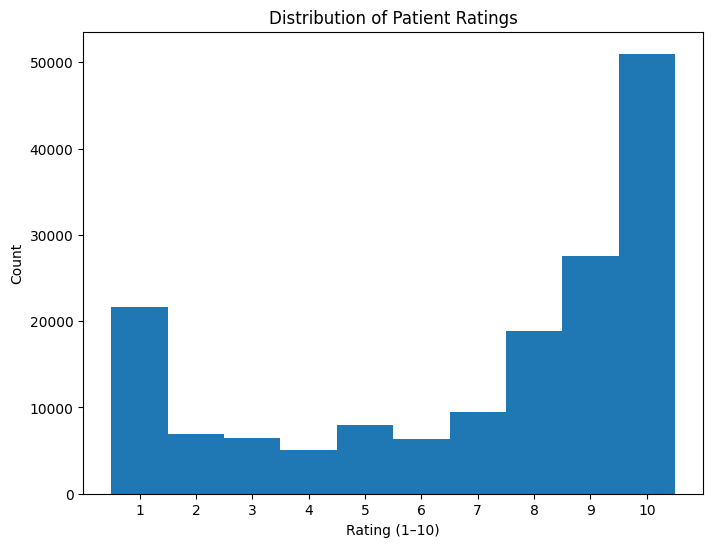

In [ ]:

# Ratings distribution
fig = plt.figure(figsize=(8,6))
ratings = df['rating'].astype(int)
bins = np.arange(0.5, 10.5+1, 1.0)
plt.hist(ratings, bins=bins)
plt.title("Distribution of Patient Ratings")
plt.xlabel("Rating (1–10)"); plt.ylabel("Count")
plt.xticks(range(1, 11)); plt.show()


Average review length: 458.73
Min: 3 | Max: 10787


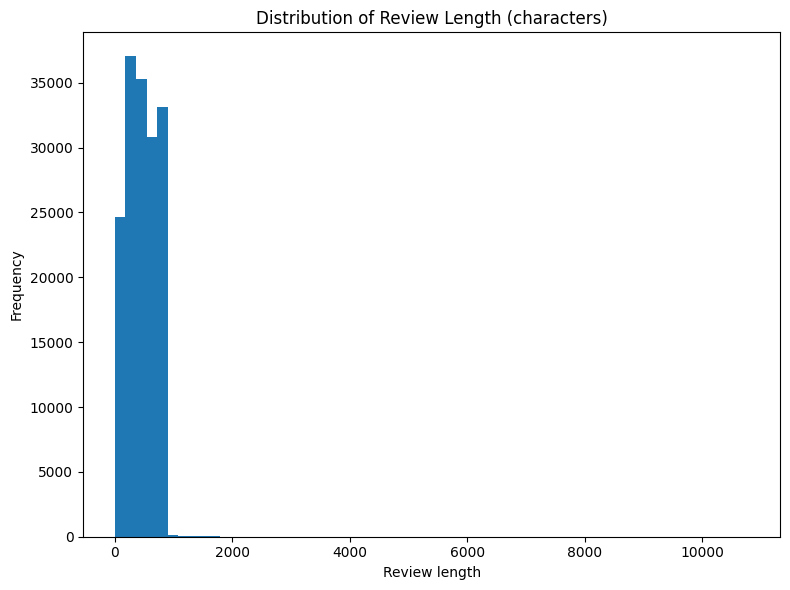

In [ ]:

# Review length stats + histogram
df['review_length'] = df['review'].astype(str).apply(len)
print(f"Average review length: {df['review_length'].mean():.2f}")
print(f"Min: {df['review_length'].min()} | Max: {df['review_length'].max()}")

fig = plt.figure(figsize=(8,6))
plt.hist(df['review_length'].values, bins=60)
plt.title("Distribution of Review Length (characters)")
plt.xlabel("Review length"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()


## 4) Preprocessing & Splits

In [ ]:
def clean_text_basic(s: str) -> str:
    """
    Basic text cleaning function:
    - Ensures input is a string
    - Removes HTML tags and line breaks (<br>)
    - Removes all non-alphanumeric characters (punctuation, symbols)
    - Converts to lowercase
    - Normalizes whitespace (single spaces)
    """
    if not isinstance(s, str): return ""
    s = re.sub(r"<br\s*/?>", " ", s)
    s = re.sub(r"<.*?>", " ", s)
    s = re.sub(r"[^a-zA-Z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s


def clean_text_lem(s: str) -> str:
    """
    Advanced text cleaning with lemmatization and stopword removal:
    - Same steps as clean_text_basic
    - Tokenizes the text (splits by spaces)
    - Removes English stopwords (common words like 'the', 'is', etc.)
    - Applies lemmatization (reduces words to their root form)
    Example: "running" -> "run", "better" -> "good"
    """
    if not isinstance(s, str): return ""
    s = re.sub(r"<br\s*/?>", " ", s)
    s = re.sub(r"<.*?>", " ", s)
    s = re.sub(r"[^a-zA-Z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip().lower()
    toks = s.split()
    if stop_en: toks = [t for t in toks if t not in stop_en]
    if lemm is not None: toks = [lemm.lemmatize(t) for t in toks]
    return " ".join(toks)


def build_text(df: pd.DataFrame, cleaner=clean_text_basic) -> pd.Series:
    """
    Builds the final text input used for modeling by concatenating:
    - Cleaned review text
    - Drug name and condition (providing additional context)
    Example output:
        "this drug helped me [DRUG] ibuprofen [COND] headache"
    Adding markers like [DRUG] and [COND] helps TF-IDF or embeddings
    differentiate between parts of the input.
    """
    rv = df['review'].map(cleaner)
    dn = df['drugName'].fillna("unknown").map(cleaner)
    cd = df['condition'].fillna("unknown").map(cleaner)
    return rv + " [DRUG] " + dn + " [COND] " + cd


def map_3class(r: float) -> int:
    """
    Converts numeric rating (1–10) to 3 sentiment classes:
    - 0: Negative (1–4)
    - 1: Neutral (5–6)
    - 2: Positive (7–10)
    """
    if r <= 4: return 0
    elif r <= 6: return 1
    else: return 2


def stratified_split(X, y, test_size=0.2, seed=42):
    """
    Performs a stratified train/validation split.
    Ensures class proportions are preserved in both sets.
    - X: input features (text)
    - y: target labels (ratings)
    """
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    (tri, vai), = sss.split(X, y)
    return tri, vai


# Select cleaner to use: lemmatization version if possible, else basic cleaning
CLEANER = clean_text_lem if lemm is not None and len(stop_en) > 0 else clean_text_basic

# Build full text dataset and label mappings (3-class and 10-class)
X_text = build_text(df, cleaner=CLEANER)
y3, y10 = df['rating'].apply(map_3class), df['rating'].astype(int).clip(1,10)

# Perform stratified splits for both tasks (3-class and 10-class)
tr3, va3   = stratified_split(X_text, y3.values)
tr10, va10 = stratified_split(X_text, y10.values)

# Create final train and validation subsets
X3_tr, X3_va   = X_text.iloc[tr3],  X_text.iloc[va3]
y3_tr, y3_va   = y3.iloc[tr3],      y3.iloc[va3]
X10_tr, X10_va = X_text.iloc[tr10], X_text.iloc[va10]
y10_tr, y10_va = y10.iloc[tr10],    y10.iloc[va10]

# Print summary of preprocessing
print("Cleaner:", CLEANER.__name__)
print("3-class:", len(X3_tr), len(X3_va), "| 10-class:", len(X10_tr), len(X10_va))


Cleaner: clean_text_basic
3-class: 129037 32260 | 10-class: 129037 32260


## 5) Helpers

In [ ]:
def evaluate_and_print(y_true, y_pred, labels, title):
    """
    Evaluates model performance and prints key metrics and visualizations.

    Steps:
    1. Calculates evaluation metrics:
       - Accuracy
       - Macro-F1
       - Weighted-F1

    2. Prints a formatted summary of performance, including:
       - Accuracy, Macro-F1, and Weighted-F1.
       - Full classification report (precision, recall, F1-score, and support per class).

    3. Generates and visualizes a confusion matrix:
       - Rows represent true classes.
       - Columns represent predicted classes.

    Parameters:
        y_true : True labels from the dataset.
        y_pred : Predicted labels from the model.
        labels : Ordered list of class labels to display in the confusion matrix.
        title : Title for the printed output and confusion matrix plot.

    Returns:
        dict : A dictionary containing evaluation metrics and the confusion matrix:
            {
                "acc": accuracy score,
                "f1_macro": macro F1 score,
                "f1_weighted": weighted F1 score,
                "cm": confusion matrix (as ndarray)
            }
    """
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    f1w = f1_score(y_true, y_pred, average='weighted')
    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f} | Weighted-F1: {f1w:.4f}")
    print(classification_report(y_true, y_pred, target_names=[str(l) for l in labels]))

    # Create confusion matrix and plot it
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig = plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix — {title}")
    plt.colorbar()

    # Define ticks and labels
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)

    # Annotate each cell with its count
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha='center', va='center')

    # Label axes
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.tight_layout()
    plt.show()

    # Return results for later comparison or logging
    return {"acc": acc, "f1_macro": f1m, "f1_weighted": f1w, "cm": cm}


## 6) Approach A — TF‑IDF + Logistic Regression

Fitting TF-IDF on 3-class training data to inspect features...
 TF-IDF matrix shape: (129037, 193448)
 Number of features (vocabulary size): 193,448

 Training TF-IDF + Logistic Regression (3-class)...

TF-IDF 3-class — Best params: {'clf__C': 10}

=== TF-IDF + LR (3-class) ===
Accuracy: 0.8722 | Macro-F1: 0.7824 | Weighted-F1: 0.8731
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      8015
           1       0.58      0.59      0.59      2871
           2       0.94      0.92      0.93     21374

    accuracy                           0.87     32260
   macro avg       0.78      0.79      0.78     32260
weighted avg       0.87      0.87      0.87     32260



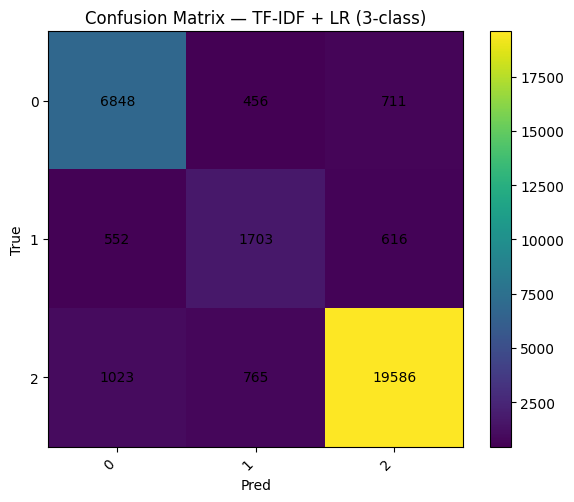


 Training TF-IDF + Logistic Regression (10-class)...

TF-IDF 10-class — Best params: {'clf__C': 10}

=== TF-IDF + LR (10-class) ===
Accuracy: 0.6542 | Macro-F1: 0.6044 | Weighted-F1: 0.6536
              precision    recall  f1-score   support

           1       0.72      0.82      0.77      4324
           2       0.61      0.54      0.57      1386
           3       0.61      0.57      0.59      1303
           4       0.65      0.56      0.60      1002
           5       0.54      0.53      0.54      1603
           6       0.57      0.51      0.54      1269
           7       0.54      0.54      0.54      1891
           8       0.53      0.57      0.55      3778
           9       0.58      0.60      0.59      5506
          10       0.77      0.74      0.75     10198

    accuracy                           0.65     32260
   macro avg       0.61      0.60      0.60     32260
weighted avg       0.65      0.65      0.65     32260



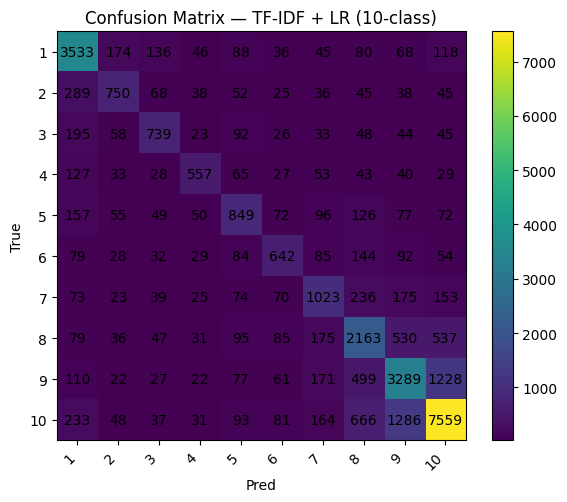


 Training complete. Best models stored as `best_tfidf_3` and `best_tfidf_10`.


In [ ]:
# TF-IDF + Logistic Regression (3-class & 10-class)
# Includes feature count inspection and GridSearch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import numpy as np

# --- 1️) Build and inspect TF-IDF vectorizer ---
tfidf = TfidfVectorizer(
    ngram_range=(2, 2),        # Only bigrams
    min_df=5,                  # Ignore rare bigrams
    max_df=0.8,                # Ignore overly common ones
    max_features=200_000,      # Upper limit on feature count
    sublinear_tf=True          # Use log-scaling for term frequency
)

# Fit only on training data to inspect vocabulary size
print("Fitting TF-IDF on 3-class training data to inspect features...")
X3_tfidf_sample = tfidf.fit_transform(X3_tr)
print(f" TF-IDF matrix shape: {X3_tfidf_sample.shape}")
print(f" Number of features (vocabulary size): {len(tfidf.get_feature_names_out()):,}\n")

# --- 2) Define pipeline and parameter grid ---
pipe_tfidf = Pipeline([
    ("tfidf", tfidf),
    ("clf", LogisticRegression(max_iter=2000, solver='lbfgs', class_weight='balanced'))
])

param_grid = {
    "clf__C": [0.5, 1, 5, 10]   # Regularization strength
}

# --- 3) 3-class classification ---
print(" Training TF-IDF + Logistic Regression (3-class)...")
grid3 = GridSearchCV(pipe_tfidf, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
grid3.fit(X3_tr, y3_tr)

y3_pred = grid3.best_estimator_.predict(X3_va)
print(f"\nTF-IDF 3-class — Best params: {grid3.best_params_}")
res_tf_3 = evaluate_and_print(y3_va, y3_pred, labels=[0, 1, 2], title="TF-IDF + LR (3-class)")

# --- 4) 10-class classification ---
print("\n Training TF-IDF + Logistic Regression (10-class)...")
grid10 = GridSearchCV(pipe_tfidf, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
grid10.fit(X10_tr, y10_tr)

y10_pred = grid10.best_estimator_.predict(X10_va)
print(f"\nTF-IDF 10-class — Best params: {grid10.best_params_}")
res_tf_10 = evaluate_and_print(y10_va, y10_pred, labels=list(range(1, 11)), title="TF-IDF + LR (10-class)")

# --- 5) Save best models for later use ---
best_tfidf_3 = grid3.best_estimator_
best_tfidf_10 = grid10.best_estimator_

print("\n Training complete. Best models stored as `best_tfidf_3` and `best_tfidf_10`.")


## 7) Approach B — Embeddings + Logistic Regression

Batches:   0%|          | 0/4033 [00:00<?, ?it/s]

Batches:   0%|          | 0/1009 [00:00<?, ?it/s]

Batches:   0%|          | 0/4033 [00:00<?, ?it/s]

Batches:   0%|          | 0/1009 [00:00<?, ?it/s]

Embeddings 3-class — Best params: {'clf__C': 10}

=== Embeddings + LR (3-class) ===
Accuracy: 0.7457 | Macro-F1: 0.4785 | Weighted-F1: 0.7043
              precision    recall  f1-score   support

           0       0.64      0.54      0.59      8015
           1       0.18      0.00      0.01      2871
           2       0.77      0.92      0.84     21374

    accuracy                           0.75     32260
   macro avg       0.53      0.49      0.48     32260
weighted avg       0.69      0.75      0.70     32260



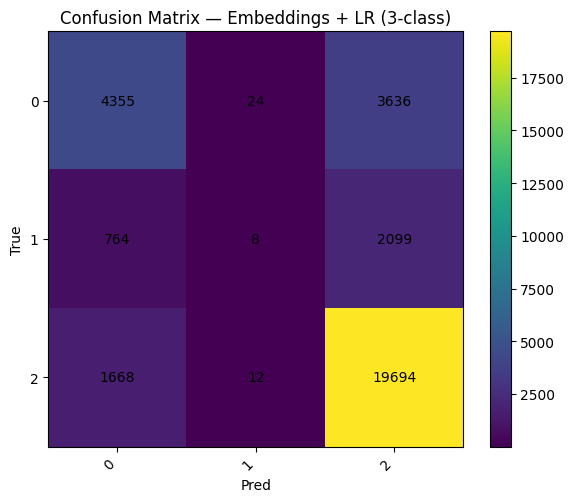

Embeddings 10-class — Best params: {'clf__C': 10}

=== Embeddings + LR (10-class) ===
Accuracy: 0.3943 | Macro-F1: 0.1645 | Weighted-F1: 0.3125
              precision    recall  f1-score   support

           1       0.41      0.65      0.50      4324
           2       0.25      0.02      0.03      1386
           3       0.15      0.03      0.05      1303
           4       0.11      0.01      0.02      1002
           5       0.16      0.04      0.07      1603
           6       0.09      0.00      0.01      1269
           7       0.14      0.01      0.02      1891
           8       0.22      0.13      0.17      3778
           9       0.26      0.16      0.19      5506
          10       0.45      0.82      0.58     10198

    accuracy                           0.39     32260
   macro avg       0.22      0.19      0.16     32260
weighted avg       0.31      0.39      0.31     32260



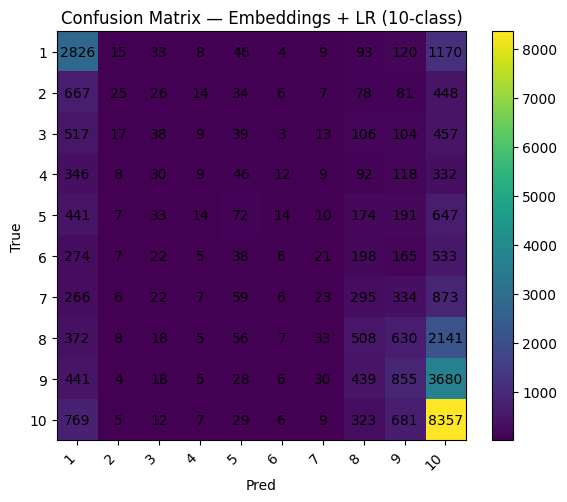

In [ ]:
from sentence_transformers import SentenceTransformer

# Load pre-trained SentenceTransformer model (MiniLM)
st_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode the text data into embeddings
X3_tr_emb  = st_model.encode(X3_tr.tolist(), show_progress_bar=True, normalize_embeddings=True)
X3_va_emb  = st_model.encode(X3_va.tolist(), show_progress_bar=True, normalize_embeddings=True)
X10_tr_emb = st_model.encode(X10_tr.tolist(), show_progress_bar=True, normalize_embeddings=True)
X10_va_emb = st_model.encode(X10_va.tolist(), show_progress_bar=True, normalize_embeddings=True)

# Define the classification pipeline: Logistic Regression.
pipe_emb = Pipeline([("clf", LogisticRegression(max_iter=2000, solver='lbfgs'))])

# Define a hyperparameter grid for C (regularization strength)
param_grid_emb = {"clf__C": [0.5, 1, 5, 10]}

# --- 3-class Classification ---
# Use 3-fold cross-validation (cv=3) to find the best hyperparameter C based on Macro-F1 score.
grid3_emb = GridSearchCV(pipe_emb, param_grid_emb, cv=3, scoring="f1_macro", n_jobs=-1)

# Train model on training embeddings
grid3_emb.fit(X3_tr_emb, y3_tr)

# Predict on validation embeddings
y3_pred_emb = grid3_emb.best_estimator_.predict(X3_va_emb)

# Display best parameters and performance results
print("Embeddings 3-class — Best params:", grid3_emb.best_params_)
res_emb_3 = evaluate_and_print(y3_va, y3_pred_emb, labels=[0,1,2], title="Embeddings + LR (3-class)")

# --- 10-class Classification ---
# Repeat the same process for the fine-grained 10-class rating task.
grid10_emb = GridSearchCV(pipe_emb, param_grid_emb, cv=3, scoring="f1_macro", n_jobs=-1)
grid10_emb.fit(X10_tr_emb, y10_tr)
y10_pred_emb = grid10_emb.best_estimator_.predict(X10_va_emb)

# Display best parameters and evaluation results
print("Embeddings 10-class — Best params:", grid10_emb.best_params_)
res_emb_10 = evaluate_and_print(y10_va, y10_pred_emb, labels=list(range(1,11)), title="Embeddings + LR (10-class)")

# Store best models for later use on test data
best_emb_3  = grid3_emb.best_estimator_
best_emb_10 = grid10_emb.best_estimator_


## 8) Final Evaluation on Test Set

Loading test set...
Test samples: 53766

3-class test distribution:
rating
2    0.659
0    0.251
1    0.090
Name: proportion, dtype: float64

Encoding test embeddings with MiniLM...


Batches:   0%|          | 0/1681 [00:00<?, ?it/s]


=== MiniLM + Logistic Regression (3-class) — TEST ===

=== MiniLM + LR (3-class) [TEST] ===
Accuracy: 0.7420 | Macro-F1: 0.4769 | Weighted-F1: 0.7001
              precision    recall  f1-score   support

           0       0.64      0.54      0.59     13497
           1       0.26      0.00      0.01      4829
           2       0.77      0.92      0.84     35440

    accuracy                           0.74     53766
   macro avg       0.56      0.49      0.48     53766
weighted avg       0.69      0.74      0.70     53766



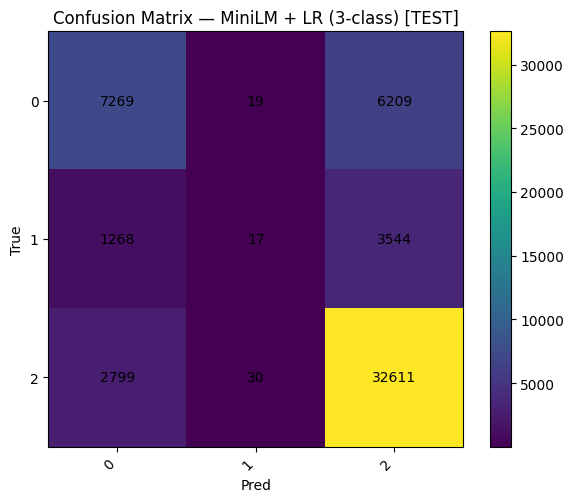


=== MiniLM + Logistic Regression (10-class) — TEST ===

=== MiniLM + LR (10-class) [TEST] ===
Accuracy: 0.3889 | Macro-F1: 0.1619 | Weighted-F1: 0.3080
              precision    recall  f1-score   support

           1       0.41      0.64      0.50      7299
           2       0.17      0.01      0.03      2334
           3       0.13      0.02      0.04      2205
           4       0.18      0.02      0.03      1659
           5       0.16      0.04      0.07      2710
           6       0.14      0.01      0.01      2119
           7       0.14      0.01      0.03      3091
           8       0.21      0.13      0.16      6156
           9       0.26      0.15      0.19      9177
          10       0.44      0.81      0.57     17016

    accuracy                           0.39     53766
   macro avg       0.22      0.18      0.16     53766
weighted avg       0.30      0.39      0.31     53766



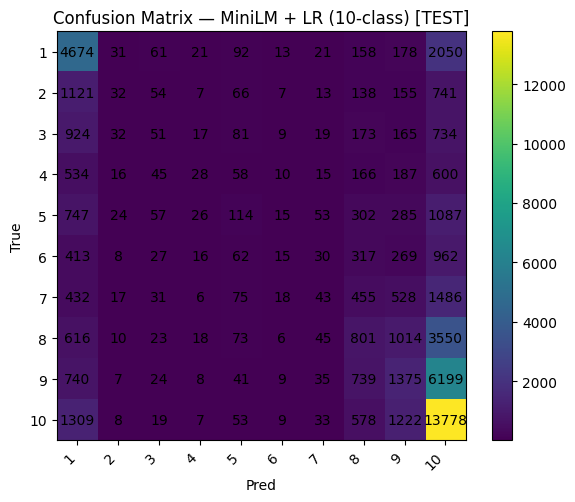


=== TF-IDF + Logistic Regression (3-class) — TEST ===

=== TF-IDF + LR (3-class) [TEST] ===
Accuracy: 0.8739 | Macro-F1: 0.7869 | Weighted-F1: 0.8745
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     13497
           1       0.60      0.59      0.60      4829
           2       0.94      0.92      0.93     35440

    accuracy                           0.87     53766
   macro avg       0.78      0.79      0.79     53766
weighted avg       0.88      0.87      0.87     53766



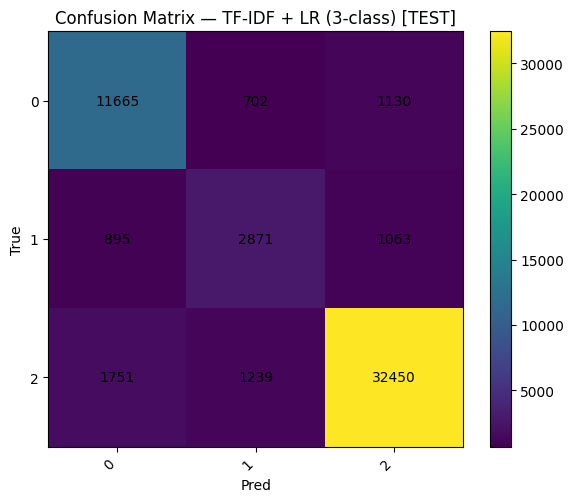


=== TF-IDF + Logistic Regression (10-class) — TEST ===

=== TF-IDF + LR (10-class) [TEST] ===
Accuracy: 0.6530 | Macro-F1: 0.6019 | Weighted-F1: 0.6526
              precision    recall  f1-score   support

           1       0.73      0.81      0.77      7299
           2       0.60      0.57      0.59      2334
           3       0.59      0.56      0.58      2205
           4       0.61      0.54      0.58      1659
           5       0.57      0.54      0.56      2710
           6       0.57      0.50      0.53      2119
           7       0.53      0.53      0.53      3091
           8       0.54      0.58      0.56      6156
           9       0.58      0.60      0.59      9177
          10       0.77      0.74      0.75     17016

    accuracy                           0.65     53766
   macro avg       0.61      0.60      0.60     53766
weighted avg       0.65      0.65      0.65     53766



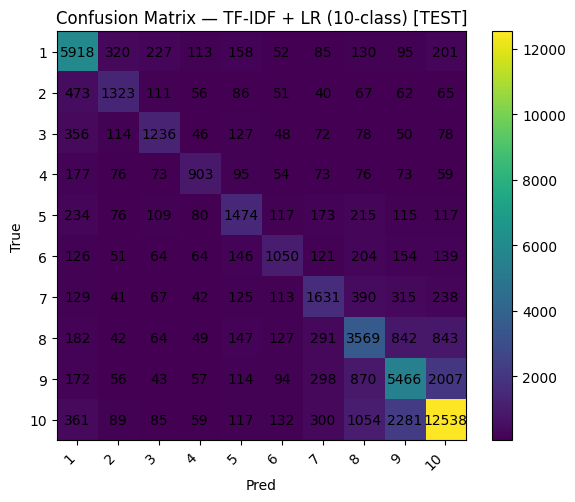


=== Validation vs. Test Summary ===


,Model,Validation Accuracy,Test Accuracy,Validation Macro-F1,Validation Weighted-F1,Test Macro-F1,Test Weighted-F1
0,TF-IDF (3-class),0.872195,0.873898,0.782425,0.873062,0.786864,0.874505
1,TF-IDF (10-class),0.654185,0.652978,0.604445,0.653563,0.601913,0.652638
2,MiniLM (3-class),0.745722,0.742049,0.478498,0.704271,0.476887,0.700144
3,MiniLM (10-class),0.394265,0.388926,0.164464,0.312478,0.161898,0.308021


In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

# --- Load Test Data ---
print("Loading test set...")
test_df = pd.read_csv("/content/drugsComTest_raw.csv", engine="python")
print(f"Test samples: {len(test_df)}")

# Build text representation using the same cleaning pipeline
X_test_text = build_text(test_df, cleaner=CLEANER)

# Create 3-class and 10-class labels
y3_test = test_df['rating'].apply(map_3class)
y10_test = test_df['rating'].astype(int).clip(1, 10)

print("\n3-class test distribution:")
print(y3_test.value_counts(normalize=True).round(3))

# --- Evaluate Transformer Embeddings (MiniLM) ---
print("\nEncoding test embeddings with MiniLM...")
X_test_emb = st_model.encode(X_test_text.tolist(), show_progress_bar=True, normalize_embeddings=True)

# --- 3-class ---
print("\n=== MiniLM + Logistic Regression (3-class) — TEST ===")
y3_test_pred_emb = best_emb_3.predict(X_test_emb)
res_test_emb_3 = evaluate_and_print(
    y3_test, y3_test_pred_emb, labels=[0, 1, 2],
    title="MiniLM + LR (3-class) [TEST]"
)
res_test_emb_3["f1_weighted"] = f1_score(y3_test, y3_test_pred_emb, average='weighted')

# --- 10-class ---
print("\n=== MiniLM + Logistic Regression (10-class) — TEST ===")
y10_test_pred_emb = best_emb_10.predict(X_test_emb)
res_test_emb_10 = evaluate_and_print(
    y10_test, y10_test_pred_emb, labels=list(range(1, 11)),
    title="MiniLM + LR (10-class) [TEST]"
)
res_test_emb_10["f1_weighted"] = f1_score(y10_test, y10_test_pred_emb, average='weighted')

# --- Evaluate TF-IDF Models ---
print("\n=== TF-IDF + Logistic Regression (3-class) — TEST ===")
y3_test_pred_tfidf = best_tfidf_3.predict(X_test_text)
res_test_tfidf_3 = evaluate_and_print(
    y3_test, y3_test_pred_tfidf, labels=[0, 1, 2],
    title="TF-IDF + LR (3-class) [TEST]"
)
res_test_tfidf_3["f1_weighted"] = f1_score(y3_test, y3_test_pred_tfidf, average='weighted')

print("\n=== TF-IDF + Logistic Regression (10-class) — TEST ===")
y10_test_pred_tfidf = best_tfidf_10.predict(X_test_text)
res_test_tfidf_10 = evaluate_and_print(
    y10_test, y10_test_pred_tfidf, labels=list(range(1, 11)),
    title="TF-IDF + LR (10-class) [TEST]"
)
res_test_tfidf_10["f1_weighted"] = f1_score(y10_test, y10_test_pred_tfidf, average='weighted')

# --- Summary Comparison Table (with Weighted-F1) ---
comparison = pd.DataFrame({
    "Model": [
        "TF-IDF (3-class)", "TF-IDF (10-class)",
        "MiniLM (3-class)", "MiniLM (10-class)"
    ],
    "Validation Accuracy": [
        res_tf_3["acc"], res_tf_10["acc"],
        res_emb_3["acc"], res_emb_10["acc"]
    ],
    "Test Accuracy": [
        res_test_tfidf_3["acc"], res_test_tfidf_10["acc"],
        res_test_emb_3["acc"], res_test_emb_10["acc"]
    ],
    "Validation Macro-F1": [
        res_tf_3["f1_macro"], res_tf_10["f1_macro"],
        res_emb_3["f1_macro"], res_emb_10["f1_macro"]
    ],
    "Validation Weighted-F1": [
        res_tf_3["f1_weighted"], res_tf_10["f1_weighted"],
        res_emb_3["f1_weighted"], res_emb_10["f1_weighted"]
    ],
    "Test Macro-F1": [
        res_test_tfidf_3["f1_macro"], res_test_tfidf_10["f1_macro"],
        res_test_emb_3["f1_macro"], res_test_emb_10["f1_macro"]
    ],
    "Test Weighted-F1": [
        res_test_tfidf_3["f1_weighted"], res_test_tfidf_10["f1_weighted"],
        res_test_emb_3["f1_weighted"], res_test_emb_10["f1_weighted"]
    ]
})

print("\n=== Validation vs. Test Summary ===")
display(comparison)


## 9) Interpretability (TF-IDF)

In [ ]:

def top_features_per_class(logreg_pipe, top_k=12):
    vec = logreg_pipe.named_steps.get('tfidf', None)
    clf = logreg_pipe.named_steps['clf']
    if vec is None:
        print("No TF-IDF in this pipeline.");
        return {}
    feats = np.array(vec.get_feature_names_out())
    coefs = clf.coef_
    if coefs.ndim == 1: coefs = coefs.reshape(1,-1)
    top = {}
    for i in range(coefs.shape[0]):
        idx = np.argsort(coefs[i])[-top_k:][::-1]
        top[i] = list(zip(feats[idx], coefs[i][idx]))
    return top

# --- TF-IDF Top Features (3-class) ---
print("\n=== Top TF-IDF Features — 3-class Model ===")
top3 = top_features_per_class(best_tfidf_3, top_k=12)
for cls, feats in top3.items():
    name = {0: 'Negative (≤4)', 1: 'Neutral (5–6)', 2: 'Positive (≥7)'}.get(cls, str(cls))
    print(f"\nClass {name}:")
    for w, val in feats:
        print(f"  {w:30s} {val: .3f}")

# --- TF-IDF Top Features (10-class) ---
print("\n=== Top TF-IDF Features — 10-class Model ===")
top10 = top_features_per_class(best_tfidf_10, top_k=10)
for cls, feats in top10.items():
    name = f"Rating {cls+1}"
    print(f"\nClass {name}:")
    for w, val in feats:
        print(f"  {w:30s} {val: .3f}")


=== Top TF-IDF Features — 3-class Model ===

Class Negative (≤4):
  not recommend                   11.803
  not worth                       9.835
  never again                     9.696
  waste of                        8.992
  039 recommend                   8.458
  no improvement                  8.271
  no relief                       7.244
  nothing for                     6.991
  will never                      6.936
  stopped taking                  6.755
  the worst                       6.685
  only positive                   6.661

Class Neutral (5–6):
  ok drug                         5.677
  was effective                   5.575
  however it                      5.294
  but do                          5.060
  works okay                      4.936
  irritable drug                  4.830
  so discontinued                 4.809
  bruising drug                   4.787
  positive no                     4.777
  helps but                       4.756
  yrs ago                     